In [1]:
import numpy as np
from scipy.stats import pearsonr
from scipy.signal import convolve
from brainiak_utils import _double_gamma_hrf
from sklearn.linear_model import Ridge
from nilearn.signal import clean
from nilearn.image import get_data
import seaborn as sns
sns.set_context('poster')
%config InLineBackend.figure_format = 'rentina'

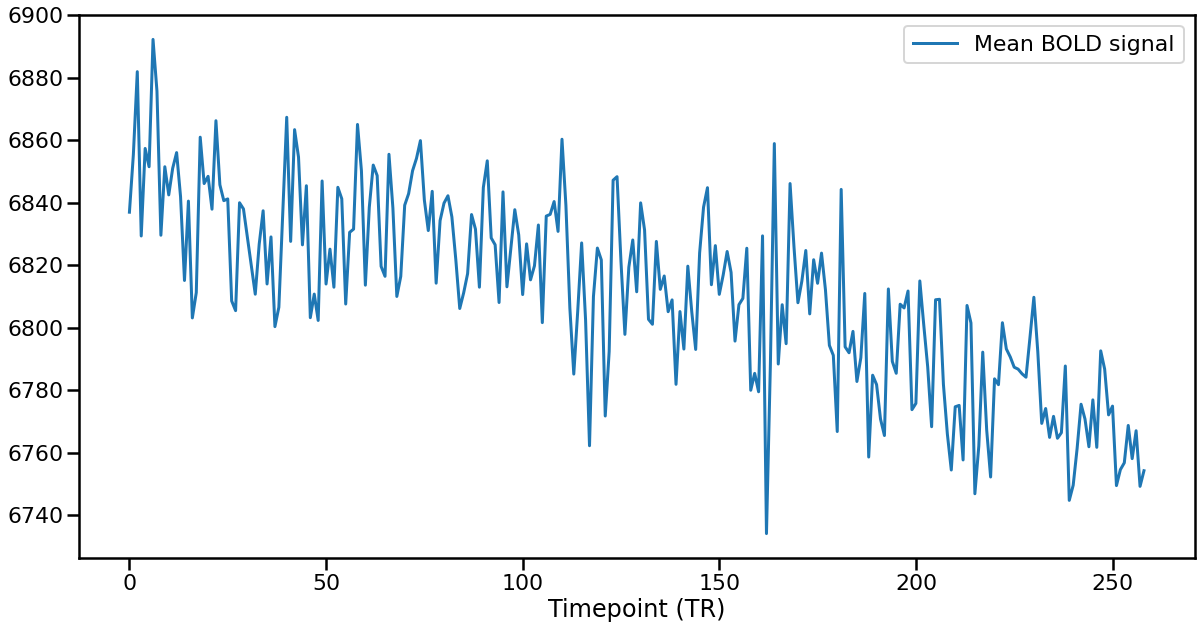

In [2]:
bold = np.loadtxt('example_data/voi.txt')
x = range(bold.shape[0])

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(x,bold,label='Mean BOLD signal');
plt.legend();
plt.xlabel('Timepoint (TR)');

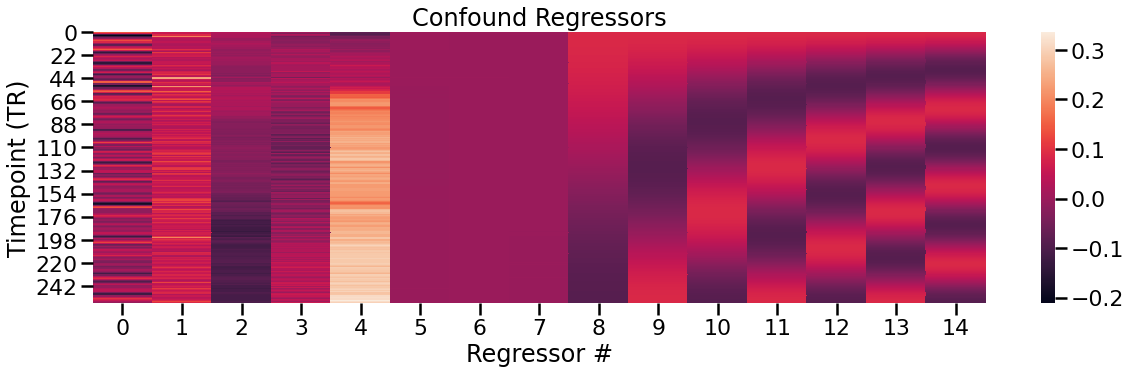

In [3]:
confounds = pd.read_csv('example_data/confoundevs.txt',sep='\t',header=None).values
# confounds = confounds[:,:15]
plt.figure(figsize=(20,5))
sns.heatmap(confounds);
plt.title('Confound Regressors');
plt.ylabel('Timepoint (TR)');
plt.xlabel('Regressor #');

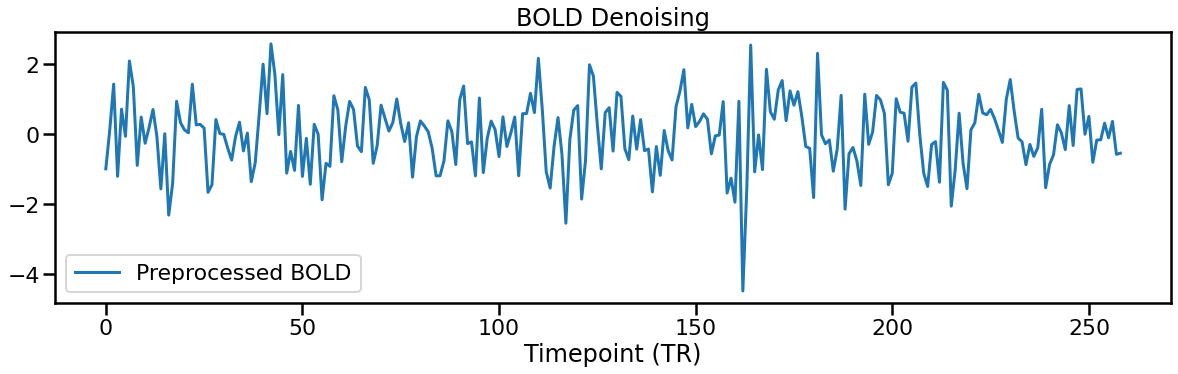

In [6]:
# bold -= bold.mean()
# preproc = clean(bold,confounds=confounds,t_r=2,detrend=False,standardize=False) #we don't detrend here because the high-pass confound regressors take care of it
preproc = clean(bold[:,np.newaxis],confounds=None,t_r=2,detrend=False,standardize='zscore')
# preproc = bold - bold.mean()
# preproc = preproc - preproc.mean()
# preproc = preproc[:,np.newaxis]
plt.figure(figsize=(20,5))
plt.plot(x,preproc,label='Preprocessed BOLD');
plt.legend();
plt.title('BOLD Denoising');
plt.xlabel('Timepoint (TR)');

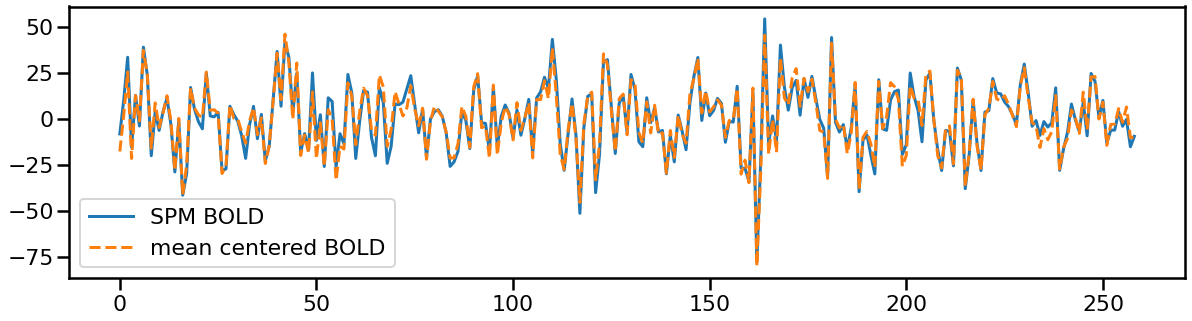

In [12]:
spm_bold = np.loadtxt('example_data/spm_bold.txt')
plt.figure(figsize=(20,5))
plt.plot(x,spm_bold,label='SPM BOLD')
mc = bold - bold.mean()
plt.plot(x,mc,'--',label='mean centered BOLD',)
plt.legend();

In [13]:
#set up parameters for deconvolution
N = preproc.shape[0] #number of timepoints
TR = 2 #TR in seconds
hrf = np.array(_double_gamma_hrf(temporal_resolution=.5)) #temporal resolution set using guidelines from brainiak
hrf /= np.max(hrf) #normalize the HRF since its in AU anyways


def dct_mat(N_,K_):
    n = np.array((range(0,N_))).T
    C_ = np.zeros((n.shape[0],K_))
    C_[:,0] = np.ones(n.shape[0])/np.sqrt(N_)
    for q in range(1,K_):
        C_[:,q] = np.sqrt(2/N_)* np.cos( np.pi*(2*n)* (q) /(2*N_))
    return C_

xb = dct_mat(N,N)

Hxb = np.zeros((N,N))
for i in range(N):
    Hx = convolve(xb[:,i],hrf)[:N]
    Hxb[:,i] = Hx
    
reg = Ridge(alpha=1,solver='lsqr',fit_intercept=False,normalize=False,max_iter=1000) #initialize the ridge regression
reg.fit(Hxb,preproc) #fit the regression
neuronal = np.matmul(xb,reg.coef_[0,:N])

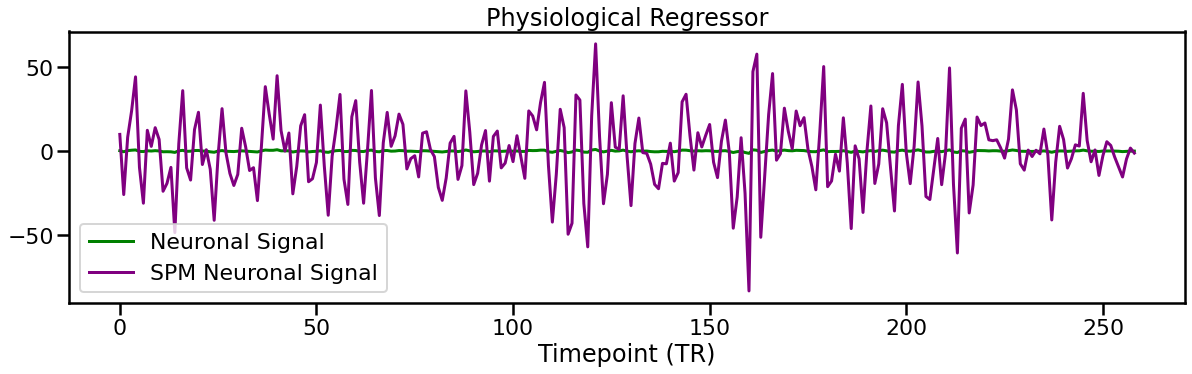

In [14]:
spm_neuronal = np.loadtxt('example_data/spm_neuronal.txt')
index = np.loadtxt('example_data/index.txt')
spm_neuronal_graph = spm_neuronal[index.astype(int)]

plt.figure(figsize=(20,5))
plt.plot(x,neuronal,label='Neuronal Signal', color='g')
plt.plot(x,spm_neuronal_graph,label='SPM Neuronal Signal', color='purple')
plt.legend();
plt.xlabel('Timepoint (TR)');
plt.title('Physiological Regressor');


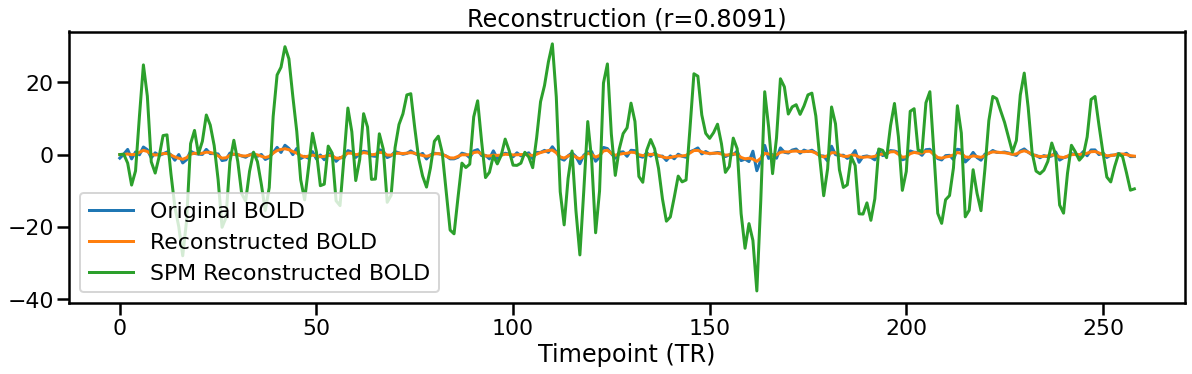

In [15]:
recon = convolve(neuronal , hrf)[:bold.shape[0]]
spm_recon = np.loadtxt('example_data/spm_recon.txt')[index.astype(int)]

plt.figure(figsize=(20,5))
plt.plot(x,preproc,label='Original BOLD')
plt.plot(x,recon,label='Reconstructed BOLD')
plt.plot(x,spm_recon,label='SPM Reconstructed BOLD')
plt.legend();
plt.xlabel('Timepoint (TR)');
plt.title('Reconstruction (r=%s)'%(np.round(pearsonr(preproc[:,0],recon)[0],4)));

In [16]:
spm_ppi = np.loadtxt('example_data/ppi_01.txt')
task = np.loadtxt('example_data/task.txt')[index.astype(int)]

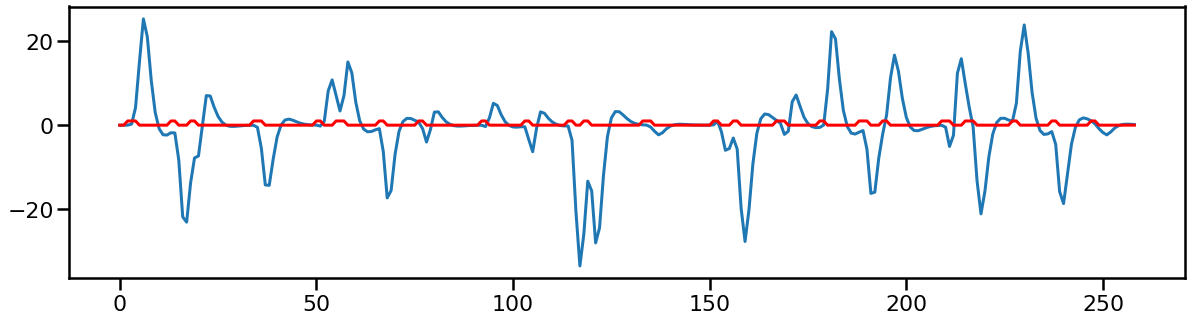

In [18]:
plt.figure(figsize=(20,5))
plt.plot(x,spm_ppi)
plt.plot(x,task,color='r')

In [ ]:
spm_neuronal.min()

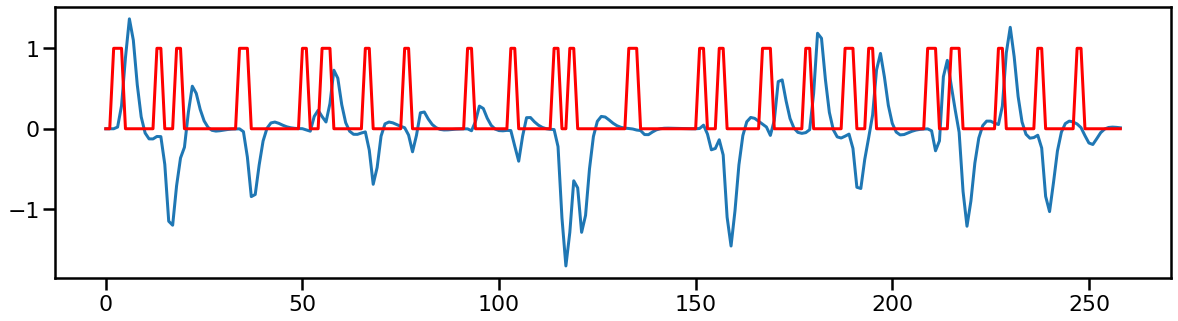

In [19]:
spm_ppi_z = np.loadtxt('example_data/ppi_01_z.txt')
plt.figure(figsize=(20,5))
plt.plot(x,spm_ppi_z)
plt.plot(x,task,color='r')